<a href="https://colab.research.google.com/github/y-oth/dst_assessment2/blob/main/report/07%20-%20ComparisonFinalModel2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Comparing interpretation methods with final model

This notebook contains a comparison of the different interpretation methods studied by Elliot, Youssef, Kyra and Jemma. Each individual method has been implemented and evaluated in detail in each person's folder in the GitHub, which includes more heatmaps and plots, so please also read these! For this notebook, we will compare all the methods using the CNN trained by Tomi.

First we clone the GitHub so that we can access Tomi's trained model, and it's trained parameters.

In [ ]:

!git clone https://github.com/y-oth/dst_assessment2
%cd dst_assessment2




Cloning into 'dst_assessment2'...
remote: Enumerating objects: 3516, done.
remote: Counting objects: 100% (110/110), done.
remote: Compressing objects: 100% (109/109), done.
remote: Total 3516 (delta 62), reused 1 (delta 1), pack-reused 3406 (from 2)
Receiving objects: 100% (3516/3516), 284.60 MiB | 6.36 MiB/s, done.
Resolving deltas: 100% (240/240), done.
Updating files: 100% (6591/6591), done.
/content/dst_assessment2


In [ ]:
import os, glob
glob.glob("**/*.pth", recursive=True)


['report/final_model.pth', 'Tomi/final_model.pth']

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F

import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np

In [ ]:
# Setting to GPU if available
device = torch.device("cuda" if torch.cuda.is_available else "cpu")
print(f"Using: {device}")

Using: cuda


# Final model

Here we create an instance of the final model that Tomi trained, and import the learned weights that have been saved, along with the optimal parameters. To do this we have to create the CNN with the exact same architecture.

In [ ]:
class FlexibleCNN(nn.Module):
    def __init__(self, n_layers, n_filters, kernel_sizes, dropout, fc_size):
        super().__init__()

        blocks = []

        in_channels = 3

        for i in range(n_layers):
            out_channels = n_filters[i]
            kernel_size = kernel_sizes[i]

            padding = (kernel_size - 1) // 2

            # Individual CNN block
            block = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size, padding=padding),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2)
            )

            blocks.append(block)

            in_channels = out_channels

        # Combine all blocks
        self.features = nn.Sequential(*blocks)

        self.dropout = dropout
        self.fc_size = fc_size

        self.classifier = None

    def _create_classifier(self, flattened_size, device):
        self.classifier = nn.Sequential(
            nn.Dropout(self.dropout),
            nn.Linear(flattened_size, self.fc_size),
            nn.ReLU(inplace=True),
            nn.Dropout(self.dropout),
            nn.Linear(self.fc_size, 4)
        ).to(device)

    def forward(self, x):
        device = x.device

        x = self.features(x)

        flattened = torch.flatten(x, 1)
        flattened_size = flattened.size(1)

        if self.classifier is None:
            self._create_classifier(flattened_size, device)

        return self.classifier(flattened)

In [ ]:
import json

# Loading the hyperparameters
with open("report/best_params.json", "r") as f:
    best_params = json.load(f)

n_layers = best_params["n_layers"]
n_filters = [best_params[f"n_filters_{i}"] for i in range(n_layers)]
kernel_sizes = [best_params[f"kernel_size_{i}"] for i in range(n_layers)]
dropout = best_params["dropout"]
fc_size = best_params["fc_size"]

learning_rate = best_params["lr"] # probably don't need this one

# Instantiating the CNN with specified hyper parameters
model = FlexibleCNN(n_layers, n_filters, kernel_sizes, dropout, fc_size).to(device)

# Dummy input to create the classifier layer
dummy_input = torch.randn(1, 3, 224, 224).to(device)
model(dummy_input)

# Loading the model with saved weights
model.load_state_dict(torch.load("report/final_model.pth"))
model.eval()

FlexibleCNN(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(256, 80, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv2d(80, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (3): Sequential(
      (0): Conv2d(48, 240, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (classifier): Sequential(
    (0): Dropout(p=0.1265531928742637, inplace=False)
    (1): Linear(in_features=47040, out_fe

## Dataloaders

Here we load in our data in exactly the same way that was done when training the model.

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

train_dataset = datasets.ImageFolder("data/Training", transform=transform)
test_dataset = datasets.ImageFolder("data/Testing",  transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True, persistent_workers=True)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True, persistent_workers=True)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


### Setting an Explainer Image:

We pick one image to compare our interpretation plots.

In [ ]:
images, labels = next(iter(test_loader))

image = images[1].to(device)         # shape (3,224,224)
label = labels[1]

input_tensor = image.unsqueeze(0)  # shape (1,3,224,224)


In [ ]:
# Make prediction
with torch.no_grad():
    output = model(image.unsqueeze(0))
    _, pred = torch.max(output, 1)

    print(f"Predicted class: {pred.item()}")
    print(f"True class: {label.item()}")

target_class = pred.item()
print(f"Target class: {target_class}")

Predicted class: 1
True class: 0
Target class: 1


# Vanilla Gradient Method Implementation

In [ ]:
def compute_vanilla_saliency(model, image_tensor, target_class, device):
    """
    Compute vanilla gradient saliency map for a single input image.
    image_tensor: shape [1, C, H, W]
    """

    model.eval()
    image_tensor = image_tensor.clone().detach().to(device)
    image_tensor.requires_grad_(True)

    # Forward pass - computes logits f(x)
    output = model(image_tensor)
    score = output[0, target_class]

    # Backward pass - compute gradient at target class
    model.zero_grad()
    score.backward()
    grads = image_tensor.grad.detach().cpu().numpy()[0]

    # Reduce channels to 2d
    saliency = np.max(np.abs(grads), axis=0)

    # Normalise to [0,1]
    saliency -= saliency.min()
    if saliency.max() != 0:
        saliency /= saliency.max()

    return saliency

# SmoothGrad Implementation

In [ ]:
def compute_smoothgrad(model, image_tensor, target_class, device,
                       n_samples=50, stdev=0.15, magnitude=True):
    """
    SmoothGrad implementation.
    Adds Gaussian noise to input and averages gradient saliency.
    Choose sigma=0.15 for reasons shown in SmoothGrad intro
    """

    model.eval()

    # Convert input to numpy for noise sampling
    x_np = image_tensor.clone().detach().cpu().numpy()
    img_min, img_max = x_np.min(), x_np.max()
    noise_std = stdev * (img_max - img_min)

    total_gradients = np.zeros_like(x_np)

    for i in range(n_samples):

        # Add Gaussian noise
        noise = np.random.normal(0, noise_std, size=x_np.shape).astype(np.float32)
        noisy_input = x_np + noise

        noisy_tensor = torch.from_numpy(noisy_input).to(device)
        noisy_tensor.requires_grad_(True)

        # Forward
        output = model(noisy_tensor)
        score = output[0, target_class]

        # Backward
        model.zero_grad()
        score.backward()

        grads = noisy_tensor.grad.detach().cpu().numpy()

        # Accumulate gradients
        if magnitude:
            total_gradients += grads * grads
        else:
            total_gradients += np.abs(grads)

    # Average
    avg_grad = total_gradients[0] / n_samples  # remove batch dim
    saliency = np.max(avg_grad, axis=0)

    # Normalise [0,1]
    saliency -= saliency.min()
    if saliency.max() != 0:
        saliency /= saliency.max()

    return saliency

In [ ]:
def show_saliency_comparison(original_img, vanilla_map, smoothgrad_map):
    fig, axs = plt.subplots(1, 3, figsize=(16,5))

    axs[0].imshow(original_img, cmap='cubehelix')
    axs[0].set_title("Original MRI")
    axs[0].axis('off')

    axs[1].imshow(vanilla_map, cmap='cubehelix')
    axs[1].set_title("Vanilla Gradient Saliency")
    axs[1].axis('off')

    axs[2].imshow(smoothgrad_map, cmap='cubehelix')
    axs[2].set_title("SmoothGrad Saliency")
    axs[2].axis('off')

    plt.tight_layout()
    plt.show()


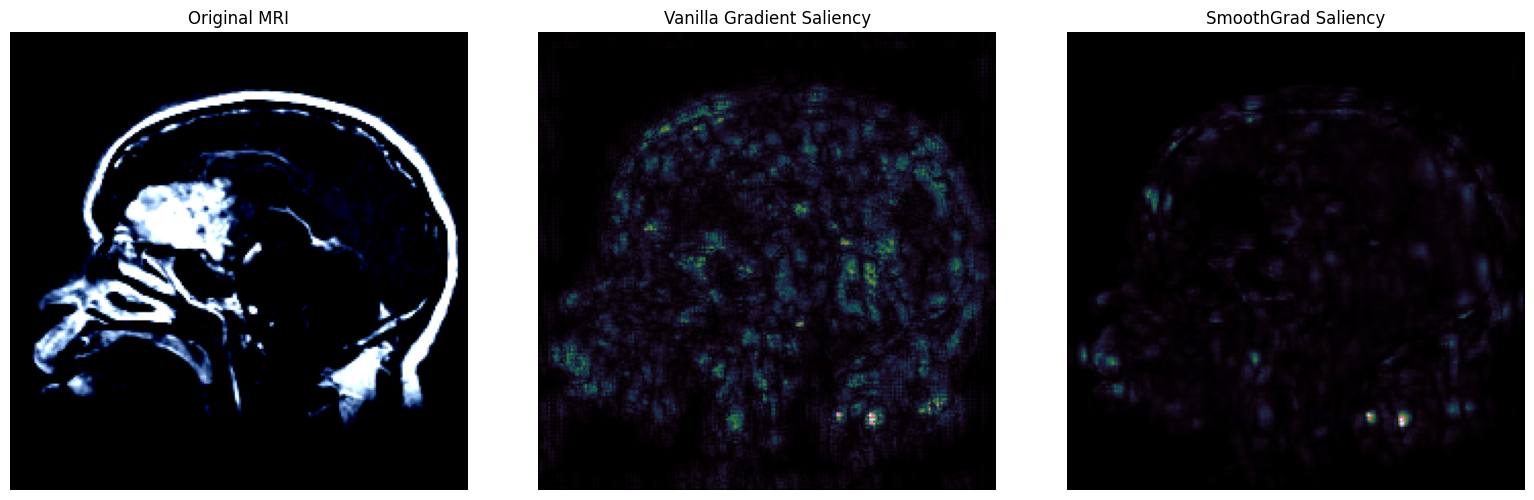

In [ ]:
# Compute saliency maps
vanilla_map = compute_vanilla_saliency(model, input_tensor, target_class, device)
smooth_map  = compute_smoothgrad(model, input_tensor, target_class, device,
                                 n_samples=50, stdev=0.15)

# Visualise
show_saliency_comparison(
    original_img = image.permute(1,2,0).cpu().numpy(),
    vanilla_map = vanilla_map,
    smoothgrad_map = smooth_map
)

# Integrated Gradients Method Implementation

In [ ]:
def integrated_gradients(model, x, baseline=None, m_steps=50):
    """
    Compute Integrated Gradients for an input x.
    model: pytorch model
    x: input image tensor of shape (1, C, H, W)
    baseline: same shape as x
    m_steps: number of steps in the Riemann approximation
    """

    model.eval()
    if baseline is None:
        baseline = torch.zeros_like(x)

    # interpolate between baseline and x
    alphas = torch.linspace(0, 1, m_steps).reshape(-1, 1, 1, 1).to(x.device)
    interpolated = baseline + alphas * (x - baseline)

    # store gradients
    gradients = []

    for i in range(m_steps):
        interpolated_i = interpolated[i].unsqueeze(0).requires_grad_(True)
        output = model(interpolated_i)
        target = output.max(1)[0]  # predicted class score

        model.zero_grad()
        target.backward()

        gradients.append(interpolated_i.grad.detach())

    # approximate integral
    avg_gradients = torch.mean(torch.stack(gradients), dim=0)

    # IG formula
    ig = (x - baseline) * avg_gradients
    return ig

# SG-IG Method Implementation

In [ ]:
def smooth_integrated_gradients(
    model, x, baseline=None, m_steps=50, n_samples=25, noise_sigma=0.1
):
    """
    Compute Smooth Integrated Gradients.
    Averaging IG over noise-perturbed copies of input 'input_tensor'.
    """

    model.eval()
    if baseline is None:
        baseline = torch.zeros_like(x)

    all_igs = []

    for _ in range(n_samples):
        noise = torch.normal(mean=0, std=noise_sigma, size=x.shape).to(x.device)
        x_noisy = x + noise
        ig = integrated_gradients(model, x_noisy, baseline, m_steps)
        all_igs.append(ig)

    return torch.mean(torch.stack(all_igs), dim=0)

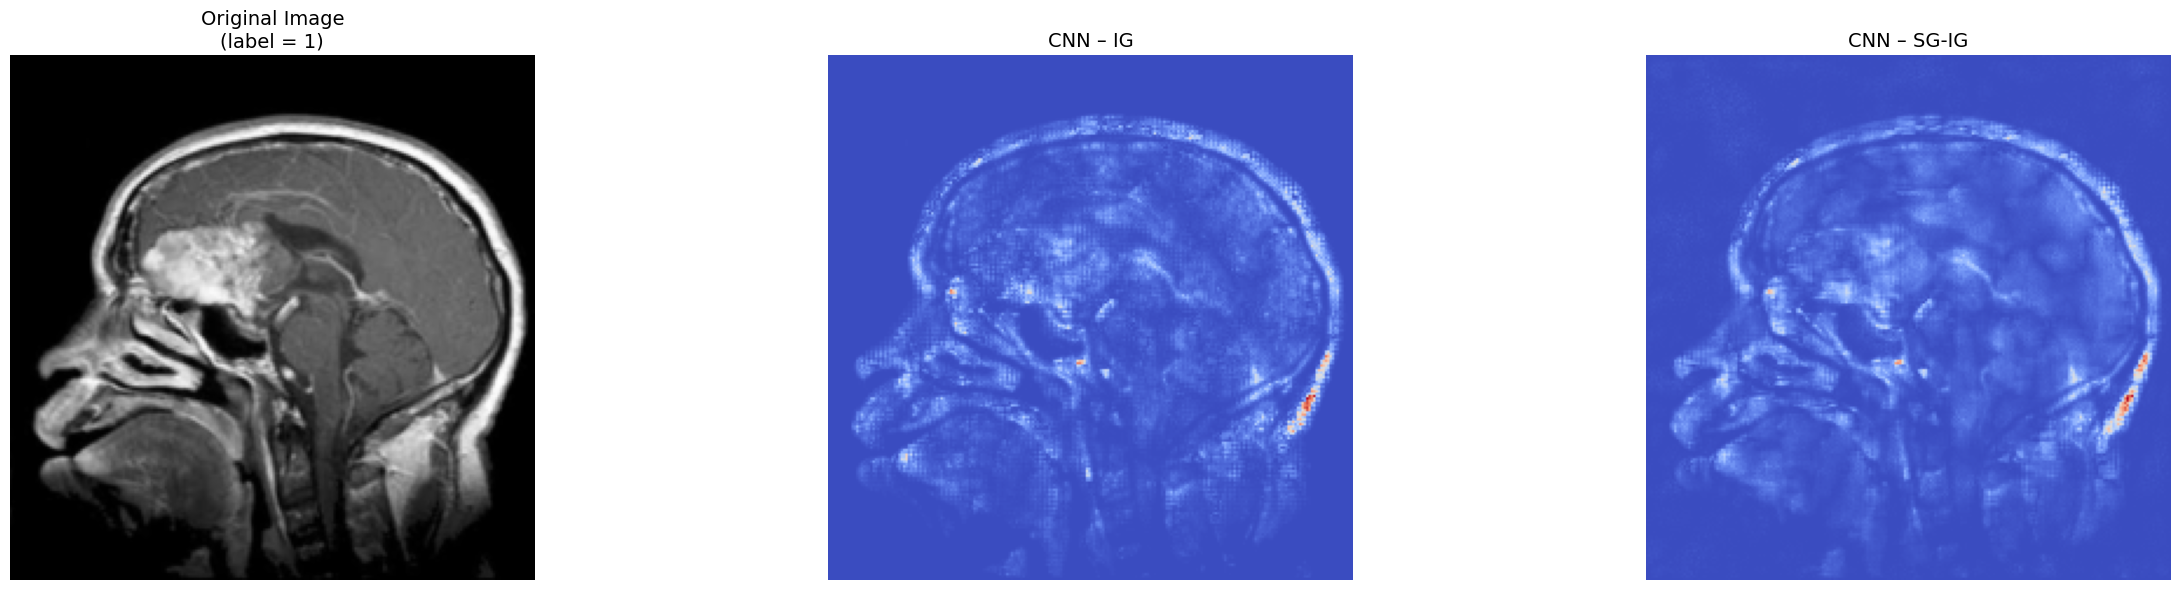

In [ ]:
explainer_image_device = input_tensor.to(device)
explainer_label = target_class
def denormalize(x, mean, std):
    mean = torch.tensor(mean).view(1, 3, 1, 1).to(x.device)
    std = torch.tensor(std).view(1, 3, 1, 1).to(x.device)
    return x * std + mean


mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

explainer_image_denorm = denormalize(explainer_image_device, mean, std)
baseline = torch.zeros_like(explainer_image_denorm)

# Compute saliency maps
cnn_ig = integrated_gradients(
    model=model,
    x=explainer_image_denorm,
    baseline=baseline,
    m_steps=50
)

cnn_sg_ig = smooth_integrated_gradients(
    model=model,
    x=explainer_image_denorm,
    baseline=baseline,
    m_steps=50,
    n_samples=20,
    noise_sigma=0.1
)



def to_heatmap(attr):
    # attr: shape (1, 3, H, W)
    attr = attr.squeeze(0).detach().cpu().numpy()   # (3, H, W)
    return np.abs(attr).mean(axis=0)                # (H, W)

def to_numpy_image(t):
    """Convert (1,3,H,W) or (3,H,W) tensor to (H,W,3) NumPy for plotting."""
    t = t.detach().cpu()
    if t.ndim == 4:  # (1,C,H,W)
        t = t.squeeze(0)
    t = t.permute(1, 2, 0)   # C,H,W → H,W,C
    return t.numpy()

# ORIGINAL IMAGE (DENORMALIZED)

orig_np = to_numpy_image(explainer_image_denorm)
orig_np = np.clip(orig_np, 0, 1)   # ensure valid RGB range


# HEATMAPS

heatmaps = [
    ("CNN – IG", to_heatmap(cnn_ig)),
    ("CNN – SG-IG", to_heatmap(cnn_sg_ig)),
]

# PLOT ALL TOGETHER
fig, axes = plt.subplots(1, 1 + len(heatmaps), figsize=(26, 6))

# Original Image
axes[0].imshow(orig_np)
axes[0].set_title(f"Original Image\n(label = {explainer_label})", fontsize=14)
axes[0].axis("off")

# Heatmaps
for ax, (title, hm) in zip(axes[1:], heatmaps):
    ax.imshow(hm, cmap="coolwarm")
    ax.set_title(title, fontsize=14)
    ax.axis("off")

plt.tight_layout()
plt.show()

Our final model is not highlighting the tumour as we can see here. This is strange because the simple CNN did highlight the tumour correctly, as did the MLP as shown in Elliot's folder. This could be due to the model overfitting.

# Grad-CAM Method Implementation

Grad-CAM requires a package, so first we install this.

In [ ]:
!pip install -q grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 79.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


We initialise the Grad-CAM class and import the functions and classes we need.

In [ ]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# Get the last block
last_block = model.features[-1]

# Extract the Conv2d layer inside that block
target_layer = last_block[0]

# Initialise GradCAM
cam = GradCAM(model=model,
              target_layers=[target_layer])


def saliency_gradcam(model, input_tensor, target_class, device="cpu"):


    """
    Computes GradCAM saliency map for a single image.
    Args:
        model: PyTorch model
        input: tensor (1,3,H,W)
        target_class: int
    Returns:
        sal_map: tensor (1,1,H,W)
    """




    model.eval()
    input_tensor = input_tensor.to(device)
    targets = [ClassifierOutputTarget(target_class)]

    grayscale_cam = cam(input_tensor, targets)[0]   # H×W numpy

    sal_map = grayscale_cam

    return sal_map



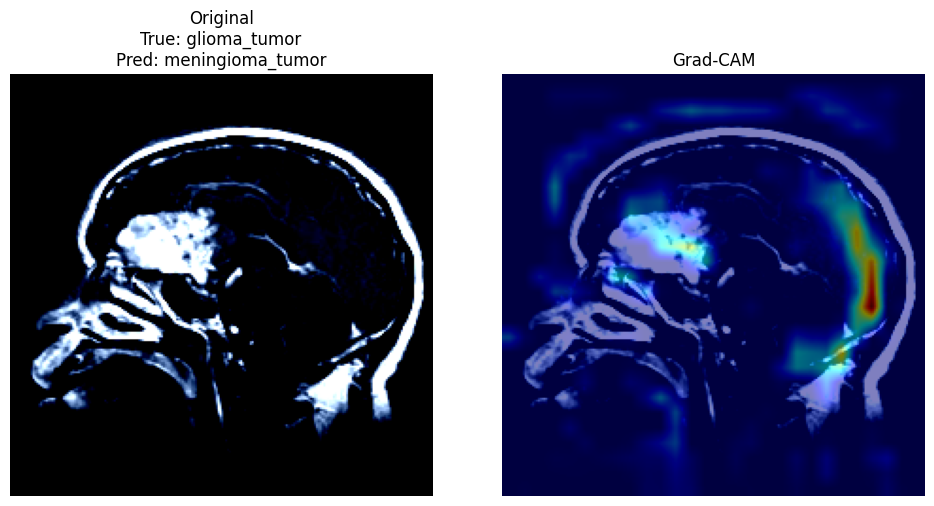

In [ ]:
import cv2
import numpy as np

# Get explainer imaage from test set

model.eval()
images, labels = next(iter(test_loader))

image = images[1].to(device)         # shape (3,224,224)
label = labels[1]


# Make prediction
with torch.no_grad():
    output = model(image.unsqueeze(0))
    _, pred = torch.max(output, 1)


# Create GradCAM heatmap
input_tensor = image.unsqueeze(0)  # shape (1,3,224,224)
target = [ClassifierOutputTarget(target_class)]

grayscale_cam = cam(input_tensor=input_tensor, targets=target)[0]

# Convert tensor image → numpy RGB image (0-1)
img = images[1].permute(1, 2, 0).cpu().numpy()
img = np.clip(img, 0, 1)

# Ensure CAM is numpy float32
grayscale_cam = grayscale_cam.astype(np.float32)

# Overlay
cam_image = show_cam_on_image(img, grayscale_cam, use_rgb=True)


# Plot GradCAM visualization

class_names = train_dataset.classes
true_label = class_names[label.item()]
pred_label = class_names[pred.item()]

plt.figure(figsize=(10, 5))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.axis('off')
plt.title(f"Original\nTrue: {true_label}\nPred: {pred_label}")

# Heatmap
plt.subplot(1, 2, 2)
plt.imshow(cam_image)
plt.axis('off')
plt.title("Grad-CAM")

plt.tight_layout()
plt.show()

The model is incorrectly identifying the back of the skull as the region of interest.

# LRP Implementation

In [ ]:
!pip -q install captum

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 42.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 128.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pytensor 2.35.1 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
shap 0.50.0 requires numpy>=2, but you have numpy 1.26.4 which is incompatible.
jaxlib 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
jax 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
op

In [ ]:
import torch
from captum.attr import LRP

def saliency_lrp(model, img, target_class, device="cpu"):
    """
    Computes LRP saliency map for a single image.
    Args:
        model: PyTorch model
        img: tensor of shape (1,3,H,W)
        target_class: int
    Returns:
        sal_map: tensor (1,1,H,W)
    """
    model.eval()
    img = img.to(device)

    lrp = LRP(model)
    R = lrp.attribute(img, target=target_class)

    return R


/usr/local/lib/python3.12/dist-packages/captum/attr/_core/lrp.py:207: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  gradient_mask = apply_gradient_requirements(input_tuple)


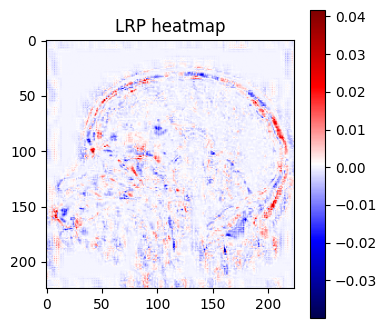

In [ ]:


lrp = LRP(model)
R = lrp.attribute(input_tensor, target=target_class)

# Convert relevance to numpy
R = R.squeeze().detach().cpu().numpy()

# Plot heatmap
plt.figure(figsize=(4,4))
plt.imshow(R[0], cmap='seismic')  # channel 0 or summed across channels
plt.colorbar()
plt.title("LRP heatmap")
plt.show()


# Quantitatively Comparing Saliency Methods: The AOPC\_MoRF Metric

In this project each group member implemented a different post-hoc interpretation method [1]
(Grad-CAM, SmoothGrad, LRP, Integrated Gradients) on the same CNN trained to classify brain tumour MRI slices.
To compare these explanations in a principled way we require a fidelity metric: a measure
of how well a saliency map identifies the specific image regions that truly drive the model’s
prediction [2]. Importantly, the goal here is explainability fidelity, not segmentation accuracy.
We are not judging how well a method outlines the tumour anatomically, but whether it
correctly highlights the regions that this particular CNN relies on [3].

---

### What is a saliency map?

A saliency map is a matrix, aligned with the input image, that assigns an *importance score*  
to each pixel or region with respect to a particular prediction. Formally, for an image $x$ and
model output $f(x)$, a saliency method produces a map:

$$
R = \{ R_i \mid i \in \text{pixels of } x \},
$$

where $R_i$ measures how influential pixel $i$ is for the model’s chosen class [4].  
Different methods compute $R$ differently:

- **Grad-CAM**: weights feature maps by the gradient of the target class and upsamples.
- **SmoothGrad**: averages gradients under noise to reduce visual noise.
- **LRP**: redistributes the output score backwards according to conservation rules.

These maps are qualitative visualisations, but we require a **quantitative** way to assess how
faithfully they reflect what the model actually uses.

---

### The AOPC\_MoRF Metric

To evaluate fidelity, we use AOPC\_MoRF (Area Over the Perturbation Curve – Most Relevant First [2],[5].
The core idea is simple:

> If a saliency map is faithful, then removing the pixels it marks as “important” should quickly
> reduce the model’s confidence.

Given an image $x$, its original score $f(x)$, and a ranking of regions from most to least
important, we progressively **delete** (perturb) the top–$k$ regions and record the model's
confidence on the modified images $x^{(k)}$.

The AOPC\_MoRF score for a single image is:

$$
\text{AOPC}_{\text{MoRF}}(x)
= \frac{1}{K} \sum_{k=1}^{K} \big[ f(x) - f(x^{(k)}) \big],
$$

where $K$ is the number of perturbation steps.  
A higher score indicates that deleting the most relevant regions causes a rapid drop in the class
score, meaning the explanation is more faithful to the model’s behaviour.

We adopt a standard perturbation function - we replace values of pixel with zero [6].

We then take the mean of this $AOPC_{MoRF}(x)$ metric over a single batch in the dataset due to limitations in computational power.

---

### Why we chose AOPC\_MoRF

Following the analysis in *Sanity Checks for Saliency Metrics* (Tomsett et al., 2020)[2], we select
AOPC\_MoRF as our primary comparison metric for three reasons:

1. **Direct fidelity assessment**  
   It directly tests whether the highlighted regions are genuinely decision-critical for the CNN.

2. **Method comparability**  
   Grad-CAM, SmoothGrad and LRP all produce scalar importance maps, allowing a unified
   ranking and deletion-based evaluation.

3. **Relative robustness in prior research**  
   Among the evaluated metrics, AOPC\_MoRF demonstrated the most stable cross-method
   behaviour, whereas alternatives such as LeRF (Least Relevant first) and single-pixel faithfulness exhibited
   sensitivity and instability .

---

### Limitations and interpretation caution

It is important to emphasise that AOPC\_MoRF is not a universally reliable or perfectly stable
metric. The paper highlights:

- high variance across images,
- sensitivity to the perturbation strategy (mean value pretubation or zero value pertubation),
- inconsistency between rankings of saliency methods image-by-image.

This metric evaluates fidelity to the model, not correctness relative to ground
truth. A saliency map can score highly while still highlighting spurious regions the model has
learned. This is an inherent limitation of post-hoc explainability and not specific to any one
method.

---

### Summary

Given these considerations, AOPC\_MoRF serves as a practical and defensible choice for
comparing our three saliency approaches in the tumour-classification context. It measures how
tightly an explanation aligns with the model’s actual decision process, while acknowledging that
no single metric captures explanation quality in a complete or reliable manner. We therefore use
AOPC\_MoRF as our **primary fidelity metric**, interpreted with transparency about its limitations
and with a focus on relative — not absolute — comparisons.

## Function that perturbs the $k$ most relevant regions

In [ ]:
def perturb_topk_regions(
    image: torch.Tensor,
    saliency: torch.Tensor,
    k: int,
    patch_size: int = 16,
    perturbation: str = "zero"
):
    """
    Perturbs the k-most relevant regions in the image based on a saliency map.

    Args:
        image (Tensor): Input image of shape (1, C, H, W).
        saliency (Tensor): Saliency map of shape (1, 1, H, W) or (H, W).
        k (int): Number of most relevant patches to perturb.
        patch_size (int): Side length of square patches.
        perturbation (str): One of ["zero", "mean"].

    Returns:
        perturbed_image (Tensor): Image after perturbation.
        deletion_mask (Tensor): Binary mask (1 = perturbed region).
        perturbed_indices (list): List of flattened patch indices.
    """

# Normalise and reshape input

    if saliency.dim() == 4:
        sal = saliency[0, 0]
    elif saliency.dim() == 3:
        sal = saliency[0]
    else:
        sal = saliency

    C, H, W = image.shape[-3:]


# Break saliency map into patches

    # number of patches along each dimension
    n_h = H // patch_size
    n_w = W // patch_size
    total_patches = n_h * n_w

    # reshape saliency into (n_h, n_w) grid of patch scores
    sal_reshaped = F.avg_pool2d(
        sal.unsqueeze(0).unsqueeze(0),
        kernel_size=patch_size,
        stride=patch_size
    ).reshape(n_h, n_w)

    # Flatten to sort by relevance
    patch_scores = sal_reshaped.flatten()            # shape (n_h*n_w)
    topk_indices = torch.topk(patch_scores, k).indices.tolist()

    #  Build deletion mask for visualisation

    deletion_mask = torch.zeros((H, W), dtype=torch.float32)

    for idx in topk_indices:
        row = idx // n_w
        col = idx % n_w

        h_start = row * patch_size
        w_start = col * patch_size

        deletion_mask[h_start:h_start+patch_size,
                      w_start:w_start+patch_size] = 1.0

    # Apply perturbation to image

    perturbed_image = image.clone()

    for idx in topk_indices:
        row = idx // n_w
        col = idx % n_w

        h_start = row * patch_size
        w_start = col * patch_size

        if perturbation == "zero":
            perturbed_image[..., h_start:h_start+patch_size,
                             w_start:w_start+patch_size] = 0.0

        elif perturbation == "mean":
            mean_val = image.mean()
            perturbed_image[..., h_start:h_start+patch_size,
                             w_start:w_start+patch_size] = mean_val

        else:
            raise ValueError("Unknown perturbation strategy")

    # reshape mask to match image dims
    deletion_mask = deletion_mask.unsqueeze(0)

    return perturbed_image, deletion_mask, topk_indices

## Function to compute the AOPC for a single image

In [ ]:
def compute_aopc_morf(
    model,
    image,
    saliency,
    max_k,
    patch_size=16,
    perturbation="zero",
    target_class=None,
    device="cpu",
):
    """
    Computes AOPC-MoRF (Most Relevant First) score for a single image and a single saliency map.
    """

    model.eval()

    #Ensure image has batch dim
    if image.dim() == 3:
        image = image.unsqueeze(0)

    image = image.to(device)

    #Handle numpy saliency
    if isinstance(saliency, np.ndarray):
        saliency = torch.from_numpy(saliency).float()

    saliency = saliency.to(device)

    #Get f(x)
    with torch.no_grad():
        logits = model(image)
        if target_class is None:
            target_class = logits.argmax(dim=1).item()
        original_score = F.softmax(logits, dim=1)[0, target_class].item()

    scores = [original_score]

    # Normalise saliency shape
    if saliency.dim() == 4:
        sal = saliency[0, 0]
    else:
        sal = saliency.squeeze()

    C, H, W = image.shape[-3:]

    # Patch grid
    n_h = H // patch_size
    n_w = W // patch_size

    # Average patch saliency
    sal_pooled = F.avg_pool2d(
        sal.unsqueeze(0).unsqueeze(0),
        kernel_size=patch_size,
        stride=patch_size
    ).reshape(n_h * n_w)

    sorted_indices = torch.argsort(sal_pooled, descending=True)

    # Perturb cumulatively
    current_img = image.clone()

    for k in range(1, max_k + 1):

        if current_img.dim() == 3:
            current_img = current_img.unsqueeze(0)

        idx = sorted_indices[k - 1].item()
        row = idx // n_w
        col = idx % n_w

        h_start = row * patch_size
        w_start = col * patch_size

        if perturbation == "zero":
            current_img[:, :, h_start:h_start+patch_size,
                            w_start:w_start+patch_size] = 0.0

        elif perturbation == "mean":
            mean_val = image.mean()
            current_img[:, :, h_start:h_start+patch_size,
                            w_start:w_start+patch_size] = mean_val

        # Compute f(x_k)
        with torch.no_grad():
            logit_k = model(current_img)
            score_k = F.softmax(logit_k, dim=1)[0, target_class].item()

        scores.append(score_k)

    # Compute AOPC-MoRF
    scores = torch.tensor(scores)
    deltas = original_score - scores[1:]
    aopc_score = deltas.mean().item()

    return aopc_score, scores.tolist()


# AOPC for Grad-CAM

In [ ]:

saliency_GC = torch.from_numpy(grayscale_cam).float()

aopc_GC, curve_GC = compute_aopc_morf(
    model,
    image,
    saliency_GC,
    max_k=20,
    patch_size=16,
    perturbation="zero",
    target_class=None,
    device=device
)

print("AOPC-MoRF Score:", aopc_GC)
print("Perturbation Curve:", curve_GC)

AOPC-MoRF Score: 0.00042638182640075684
Perturbation Curve: [0.9999651908874512, 0.9999711513519287, 0.999969482421875, 0.9999692440032959, 0.9999643564224243, 0.9999521970748901, 0.99997878074646, 0.9999833106994629, 0.9999852180480957, 0.9999853372573853, 0.9999886751174927, 0.9999532699584961, 0.9999569654464722, 0.9999148845672607, 0.9997701048851013, 0.9997475743293762, 0.9996776580810547, 0.9996781349182129, 0.9996622800827026, 0.9996024966239929, 0.9930650591850281]


# AOPC for Vanilla gradients

In [ ]:
# Prepare a test image
images, labels = next(iter(test_loader))

img = images[0].unsqueeze(0).to(device)   # [1,3,224,224]
target_class = labels[0].item()

salmap_VG = compute_vanilla_saliency(model, img, target_class, device)
aopc_VG, curve_VG = compute_aopc_morf(
    model,
    image,
    salmap_VG,
    max_k=20,
    patch_size=16,
    perturbation="zero",
    target_class=None,
    device=device
)

print("AOPC-MoRF Score:", aopc_VG)
print("Perturbation Curve:", curve_VG)

AOPC-MoRF Score: 0.06922310590744019
Perturbation Curve: [0.9999651908874512, 0.9997385144233704, 0.9999268054962158, 0.9999213218688965, 0.9998667240142822, 0.9998072981834412, 0.99968421459198, 0.9986937642097473, 0.9975913763046265, 0.984081506729126, 0.9713447690010071, 0.9895049333572388, 0.957811713218689, 0.950714647769928, 0.9629321098327637, 0.9454599022865295, 0.7216583490371704, 0.7916656732559204, 0.6529738903045654, 0.8127973079681396, 0.878666877746582]


# AOPC for SmoothGrad

In [ ]:

salmap_SG = compute_smoothgrad(model, img, target_class, device)
aopc_SG, curve_SG = compute_aopc_morf(
    model,
    image,
    salmap_SG,
    max_k=20,
    patch_size=16,
    perturbation="zero",
    target_class=None,
    device=device
)

print("AOPC-MoRF Score:", aopc_SG)
print("Perturbation Curve:", curve_SG)

AOPC-MoRF Score: 6.760955147910863e-05
Perturbation Curve: [0.9999651908874512, 0.9999295473098755, 0.9999575614929199, 0.9998762607574463, 0.9999408721923828, 0.9999909400939941, 0.9999914169311523, 0.9999822378158569, 0.9999711513519287, 0.9999262094497681, 0.9999061822891235, 0.9993528723716736, 0.99992835521698, 0.9998681545257568, 0.9999574422836304, 0.999971866607666, 0.9999297857284546, 0.9999333620071411, 0.9999090433120728, 0.9998769760131836, 0.9997513890266418]


# AOPC for Integrated Gradients

In [ ]:

baseline = torch.zeros_like(img)
salmap_IG = integrated_gradients(
        model=model,
        x=img,
        baseline=baseline,
        m_steps=50
    )
aopc_IG, curve_IG = compute_aopc_morf(
    model,
    image,
    salmap_IG,
    max_k=20,
    patch_size=16,
    perturbation="zero",
    target_class=None,
    device=device
)

print("AOPC-MoRF Score:", aopc_IG)
print("Perturbation Curve:", curve_IG)

AOPC-MoRF Score: 0.025695571675896645
Perturbation Curve: [0.9999651908874512, 0.9999710321426392, 0.9999831914901733, 0.9999762773513794, 0.9999650716781616, 0.9999065399169922, 0.9999232292175293, 0.999937891960144, 0.9999760389328003, 0.999980092048645, 0.999964714050293, 0.9999083280563354, 0.9999731779098511, 0.9999165534973145, 0.9998482465744019, 0.9978299736976624, 0.9637484550476074, 0.9375495314598083, 0.8895377516746521, 0.8009722232818604, 0.8965240716934204]


# AOPC for SG-IG

In [ ]:

baseline = torch.zeros_like(img)
salmap_SGIG = smooth_integrated_gradients(
        model=model,
        x=img,
        baseline=baseline,
        m_steps=50
    )
aopc_SGIG, curve_SGIG = compute_aopc_morf(
    model,
    image,
    salmap_SGIG,
    max_k=20,
    patch_size=16,
    perturbation="zero",
    target_class=None,
    device=device
)

print("AOPC-MoRF Score:", aopc_SGIG)
print("Perturbation Curve:", curve_SGIG)

AOPC-MoRF Score: 0.01671488955616951
Perturbation Curve: [0.9999651908874512, 0.9999710321426392, 0.9999831914901733, 0.9999762773513794, 0.9999560117721558, 0.9999065399169922, 0.9999232292175293, 0.9999704360961914, 0.9999760389328003, 0.999980092048645, 0.999964714050293, 0.9999083280563354, 0.9988559484481812, 0.9951034784317017, 0.982330322265625, 0.9951587319374084, 0.9412766695022583, 0.8857160806655884, 0.8895377516746521, 0.9812831878662109, 0.9962279796600342]


In [ ]:


lrp = LRP(model)
R = lrp.attribute(img, target=target_class)

# Convert relevance to numpy
salmap_LRP = R

aopc_LRP, curve_LRP = compute_aopc_morf(
    model,
    image,
    salmap_LRP,
    max_k=20,
    patch_size=16,
    perturbation="zero",
    target_class=None,
    device=device
)

print("AOPC-MoRF Score:", aopc_LRP)
print("Perturbation Curve:", curve_LRP)

AOPC-MoRF Score: 0.0038050382863730192
Perturbation Curve: [0.9999651908874512, 0.9999663829803467, 0.999968409538269, 0.9999827146530151, 0.9999803304672241, 0.9999185800552368, 0.9998652935028076, 0.9998078942298889, 0.9998055100440979, 0.9998528957366943, 0.9997585415840149, 0.9989684820175171, 0.9991092085838318, 0.9894262552261353, 0.9888683557510376, 0.9885357022285461, 0.9873926043510437, 0.9977460503578186, 0.9911412000656128, 0.9911876916885376, 0.9919209480285645]


# AOPC Curve Plot for Explainer Image

Here we plot the AOPC curve for all models for our single explainer image

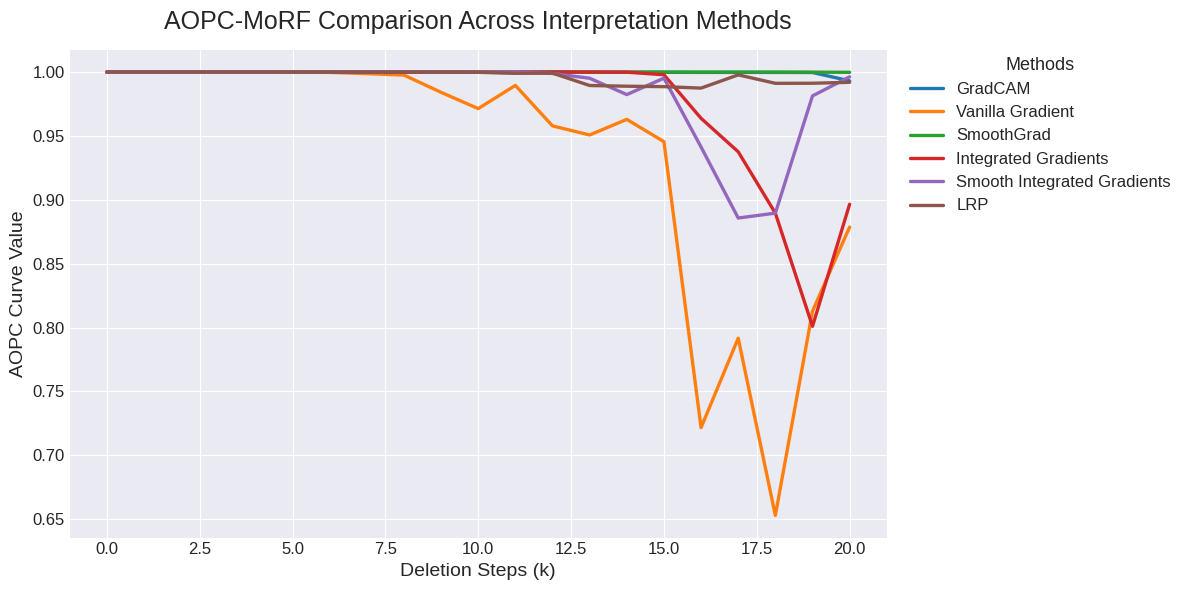

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Example curves — replace with your real ones:
# curve1, curve2, ..., curve6 must be numpy arrays of same length
methods = [
    "GradCAM",
    "Vanilla Gradient",
    "SmoothGrad",
    "Integrated Gradients",
    "Smooth Integrated Gradients",
    "LRP"
]

curves = [curve_GC, curve_VG, curve_SG, curve_IG, curve_SGIG, curve_LRP]

# Plot Style
plt.figure(figsize=(12, 6))
plt.style.use("seaborn-v0_8-darkgrid")

colors = [
    "#1f77b4",  # blue
    "#ff7f0e",  # orange
    "#2ca02c",  # green
    "#d62728",  # red
    "#9467bd",  # purple
    "#8c564b",  # brown
]

# Plot Curves
for method, curve, color in zip(methods, curves, colors):
    plt.plot(curve, label=method, linewidth=2.4, color=color)

# Formatting
plt.title("AOPC-MoRF Comparison Across Interpretation Methods", fontsize=18, pad=15)
plt.xlabel("Deletion Steps (k)", fontsize=14)
plt.ylabel("AOPC Curve Value", fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Put legend outside
plt.legend(title="Methods", fontsize=12, title_fontsize=13,
           bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0.)

plt.tight_layout()
plt.show()


### Comparison Plot of Image Scores and Perturbation Curves

/tmp/ipython-input-3783516127.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(methods, rotation=25, ha="right", fontsize=11)


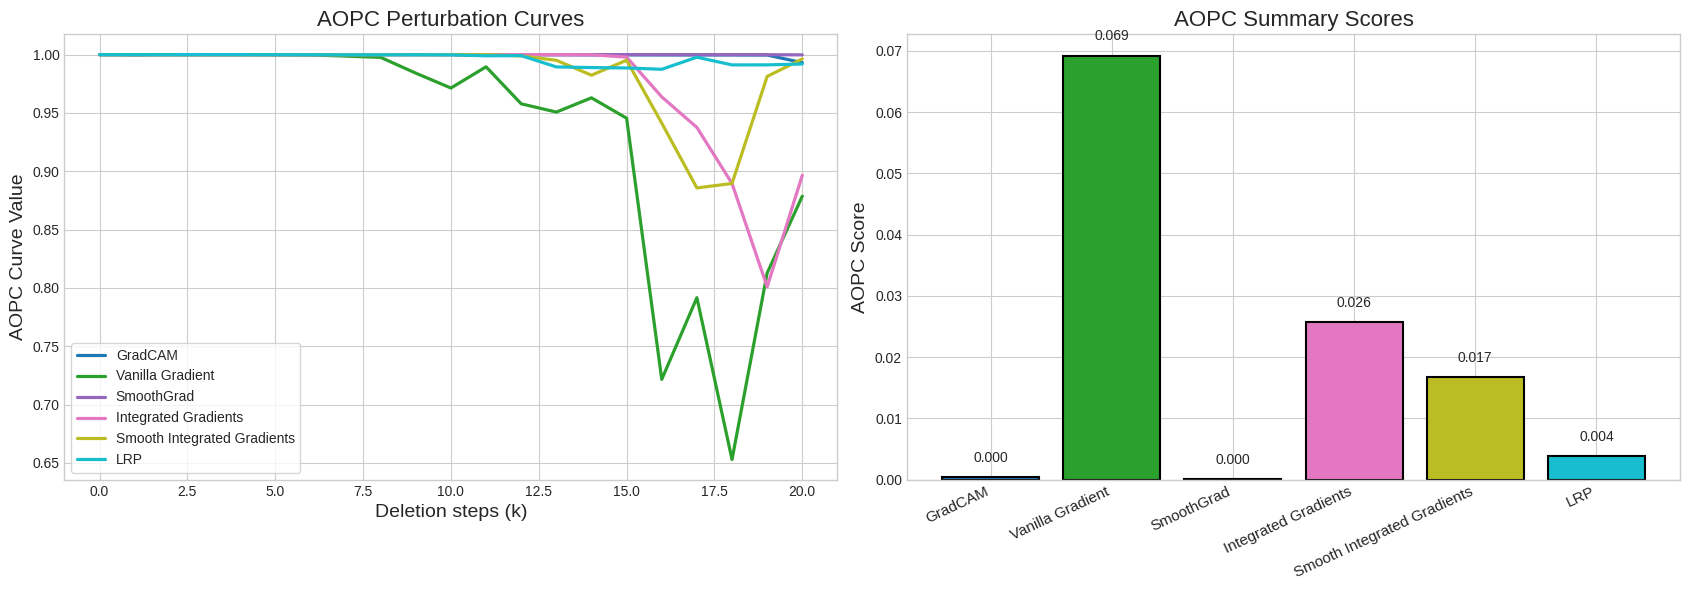

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

methods = ["GradCAM", "Vanilla Gradient", "SmoothGrad",
           "Integrated Gradients", "Smooth Integrated Gradients", "LRP"]

curves = {
    "GradCAM": curve_GC,
    "Vanilla Gradient": curve_VG,
    "SmoothGrad": curve_SG,
    "Integrated Gradients": curve_IG,
    "Smooth Integrated Gradients": curve_SGIG,
    "LRP": curve_LRP
}

summary_scores = {
    "GradCAM": aopc_GC,
    "Vanilla Gradient": aopc_VG,
    "SmoothGrad": aopc_SG,
    "Integrated Gradients": aopc_IG,
    "Smooth Integrated Gradients": aopc_SGIG,
    "LRP": aopc_LRP
}


plt.style.use("seaborn-v0_8-whitegrid")
colors = plt.cm.tab10(np.linspace(0, 1, len(methods)))

# 2-panel figure
fig, axes = plt.subplots(1, 2, figsize=(17, 6))


# PANEL 1 — AOPC CURVES
ax = axes[0]

for i, method in enumerate(methods):
    ax.plot(curves[method], label=method, linewidth=2.3, color=colors[i])

ax.set_title("AOPC Perturbation Curves", fontsize=16)
ax.set_xlabel("Deletion steps (k)", fontsize=14)
ax.set_ylabel("AOPC Curve Value", fontsize=14)
ax.legend(fontsize=10, loc="lower left", frameon=True)


# PANEL 2 — SUMMARY BAR CHART
ax2 = axes[1]

bars = ax2.bar(methods, [summary_scores[m] for m in methods],
               color=colors, edgecolor="black", linewidth=1.5)

ax2.set_title("AOPC Summary Scores", fontsize=16)
ax2.set_ylabel("AOPC Score", fontsize=14)
ax2.set_xticklabels(methods, rotation=25, ha="right", fontsize=11)

# Add numeric labels on top
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.002,
             f"{height:.3f}", ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


These plots suggest that, for this single explainer image and for this particular CNN, Vanilla Gradients appears to achieve the highest AOPC score, indicating the strongest sensitivity to perturbations in the regions it highlights. This outcome is unexpected: it does not align with typical behaviour reported in the literature, nor with the results we observed when training our own smaller CNNs individually, where our methods performed better than Vanilla Gradients.
Although this model achieves a reasonably high test accuracy (above 80%), the heatmaps reveal that, at least for this example, it is not consistently focusing on the correct tumour region. However, AOPC results based on a single image are unreliable. Attribution quality can vary substantially across inputs, and one anomalous example can easily mislead the evaluation.
This motivates using a batch of test images, and computing the mean AOPC scores across the batch. This gives us a more stable and trustworthy comparison of the different attribution methods.

# Mean Batch $AOPC_{MoRF}(x)$ :

Now let's compare all the models for a batch of images. We will choose the first batch of the test loader, and average the AOPC over this batch. Then we will be able to plot the average curves as well for a more reliable comparison of the methods.

In [ ]:

images, labels = next(iter(test_loader))
print(images.shape)


torch.Size([32, 3, 224, 224])


Here we can see that we have 32 images in our batch from the test loader, that we will average across. Now we create a function to return the saliency map for each method

In [ ]:
def saliency_fn(method, model, image_tensor, target_class, device="cuda",
                n_samples=50, stdev=0.1, magnitude=1.0,
                m_steps=50, baseline=None, noise_sigma=0.1):

    if method == "vanilla":
        return compute_vanilla_saliency(model, image_tensor, target_class, device=device)

    if method == "smoothgrad":
        return compute_smoothgrad(model, image_tensor, target_class,
                                   device=device, n_samples=n_samples, stdev=stdev)

    if method == "ig":
        return integrated_gradients(model, image_tensor, baseline=baseline, m_steps=m_steps)

    if method == "smoothig":
        return smooth_integrated_gradients(model, image_tensor, baseline=baseline,
                                 m_steps=m_steps, noise_sigma=noise_sigma, n_samples=n_samples)

    if method == "lrp":
        return saliency_lrp(model, image_tensor, target_class, device=device)

    if method == "gradcam":
        return saliency_gradcam(model, image_tensor, target_class, device=device)

    raise ValueError("Unknown saliency method")


### Compute mean AOPC by batch

In [ ]:

def compute_mean_aopc_batch(
    model,
    images,
    method,              # e.g. "smoothgrad"
    max_k=20,
    patch_size=16,
    perturbation="zero",
    device="cuda",
    **sal_kwargs         # extra saliency params
):
    model.eval()
    scores = []
    curves = []

    for img in images:
        img = img.unsqueeze(0).to(device)

        # Predict class
        with torch.no_grad():
            pred = model(img)
        pred_class = pred.argmax(dim=1).item()

        # Compute saliency map
        salmap = saliency_fn(
            method,
            model=model,
            image_tensor=img,
            target_class=pred_class,
            device=device,
            **sal_kwargs
        )

        # Compute AOPC-MoRF score and curve
        score, curve = compute_aopc_morf(
            model=model,
            image=img,
            saliency=salmap,
            max_k=max_k,
            patch_size=patch_size,
            perturbation=perturbation,
            device=device
        )

        scores.append(score)
        curves.append(torch.tensor(curve))   # convert to tensor for easy averaging

    # Average score
    mean_score = float(sum(scores) / len(scores))

    # Average curve (element-wise)
    mean_curve = torch.stack(curves).mean(dim=0).tolist()

    return mean_score, mean_curve



## Grad Cam Batch Mean computation:

In [ ]:
mean_aopc_GC, mean_curve_GC = compute_mean_aopc_batch(
    model,
    images,
    method="gradcam",
    max_k=20,
    patch_size=16,
    perturbation="zero",
    device=device
)

print("Mean Grad-CAM AOPC-MoRF over batch:", mean_aopc_GC)


Mean Grad-CAM AOPC-MoRF over batch: 0.07411571966949282


## LRP Batch mean computation:

In [ ]:
mean_aopc_LRP, mean_curve_LRP = compute_mean_aopc_batch(
    model,
    images,
    method="lrp",
    max_k=20,
    patch_size=16,
    perturbation="zero",
    device=device
)

print("Mean LRP AOPC-MoRF over batch:", mean_aopc_LRP)

/usr/local/lib/python3.12/dist-packages/captum/attr/_core/lrp.py:207: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  gradient_mask = apply_gradient_requirements(input_tuple)


Mean LRP AOPC-MoRF over batch: 0.3784632706549047


## IG batch mean computation:

In [ ]:
mean_aopc_IG, mean_curve_IG = compute_mean_aopc_batch(
    model,
    images,
    method="ig",
    max_k=20,
    patch_size=16,
    perturbation="zero",
    device=device,
    baseline=None,
    m_steps=50
)

print("Mean Integrated Gradients AOPC-MoRF over batch:", mean_aopc_IG)

Mean Integrated Gradients AOPC-MoRF over batch: 0.31164689701392945


## SmoothGrad batch mean computation:

In [ ]:
mean_aopc_SG, mean_curve_SG = compute_mean_aopc_batch(
    model,
    images,
    method="smoothgrad",
    max_k=20,
    patch_size=16,
    perturbation="zero",
    device=device,
    n_samples=50,
    stdev=0.1
)

print("Mean SmoothGrad AOPC-MoRF over batch:", mean_aopc_SG)

Mean SmoothGrad AOPC-MoRF over batch: 0.16567033044123125


## SG-IG batch mean computation:

SG-IG is too computationally heavy for the batch of images for the GPU we are using on Google Colab (runtime is too long) so it has been omitted from this comparison. A comparison of SG-IG against IG for a batch of images is shown in Elliot's folder. The code has been provided but commented out.

In [ ]:
# mean_aopc_SGIG, mean_curve_SGIG= compute_mean_aopc_batch(
#     model,
#     images,
#     method="smoothig",
#     max_k=20,
#     patch_size=16,
#     perturbation="zero",
#     device=device,
#     n_samples=50,
#     noise_sigma=0.1
# )

# print("Mean Smooth Integrated Gradients AOPC-MoRF over batch:", mean_aopc_SGIG)

## Vanilla Gradients Batch Mean computation

In [ ]:
mean_aopc_VG, mean_curve_VG = compute_mean_aopc_batch(
    model,
    images,
    method="vanilla",
    max_k=20,
    patch_size=16,
    perturbation="zero",
    device=device
)

print("Mean Vanilla Gradient AOPC-MoRF over batch:", mean_aopc_VG)

Mean Vanilla Gradient AOPC-MoRF over batch: 0.13178569856589784


# Bar Plot Comparison

In [ ]:
# Bar Plot of our Different Methods:


def plot_mean_aopc_bar(
    mean_aopc_VG,
    mean_aopc_IG,
    mean_aopc_SG,
    mean_aopc_LRP,
    mean_aopc_GC
):
    # Names and values
    methods = [
        "Vanilla Grad",
        "Integrated Grad",
        "SmoothGrad",
        "LRP",
        "GradCAM"
    ]

    aopc_values = [
        mean_aopc_VG,
        mean_aopc_IG,
        mean_aopc_SG,
        mean_aopc_LRP,
        mean_aopc_GC
    ]

    # Figure configuration
    plt.figure(figsize=(12, 6))
    bars = plt.bar(methods, aopc_values, color=[
        "#1f77b4", "#ff7f0e", "#d62728", "#9467bd", "#8c564b"
    ])

    # Add value labels on top of each bar
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width()/2,
            height + 0.001,
            f"{height:.4f}",
            ha="center",
            va="bottom",
            fontsize=10
        )

    plt.title("Comparison of Mean AOPC-MoRF Across Saliency Methods", fontsize=16)
    plt.ylabel("Mean AOPC Score")
    plt.grid(axis="y", linestyle="--", alpha=0.4)

    plt.show()


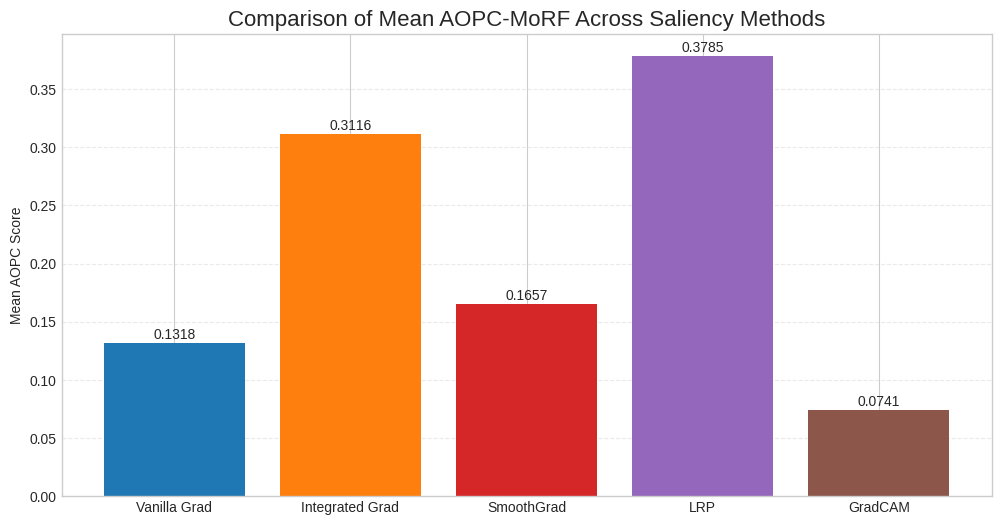

In [ ]:
plot_mean_aopc_bar(
    mean_aopc_VG,
    mean_aopc_IG,
    mean_aopc_SG,
    mean_aopc_LRP,
    mean_aopc_GC
)


LRP achieves the highest mean AOPC score, followed by IG. This indicates they are performing better than the other models, so when we plot the pertubation curves, we would expect their graphs to drop off quicker than the others. Let's plot these now.

# Plotting mean batch pertubation curves

In [ ]:
mean_curves = {
    "IG": mean_curve_IG,
    "LRP": mean_curve_LRP,
    "SmoothGrad": mean_curve_SG,
    "Vanilla Grad": mean_curve_VG,
    "GradCAM": mean_curve_GC
}

def plot_aopc_curves(curve_dict, max_k=None, title="AOPC-MoRF Comparison"):
    """
    curve_dict: {method_name: mean_curve_list}
    max_k: number of k steps (infer automatically if None)
    """

    plt.figure(figsize=(8, 6))

    for method, curve in curve_dict.items():
        curve = np.array(curve)

        if max_k is None:
            ks = np.arange(1, len(curve) + 1)
        else:
            ks = np.arange(1, max_k + 1)

        plt.plot(ks, curve, label=method, linewidth=2)

    plt.xlabel("Top-k Regions Removed", fontsize=12)
    plt.ylabel("AOPC Score", fontsize=12)
    plt.title(title, fontsize=14)
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.show()




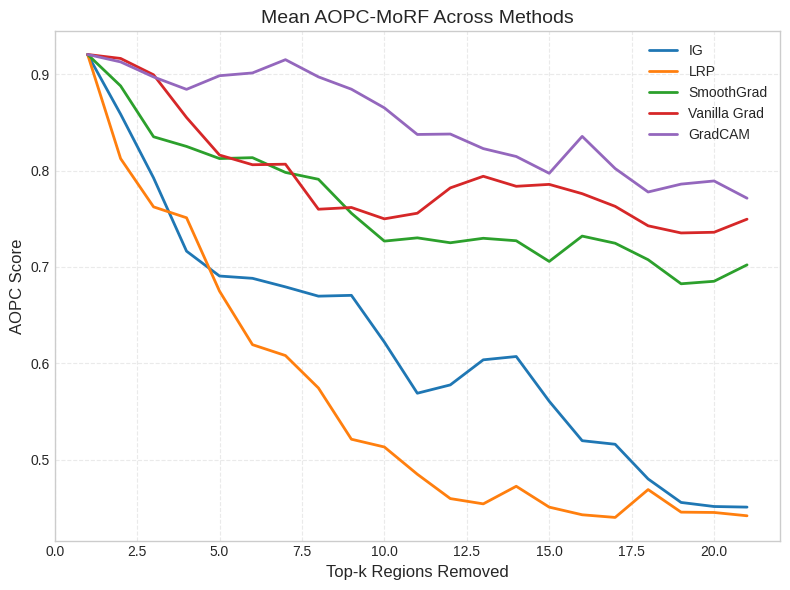

In [ ]:
plot_aopc_curves(mean_curves, title="Mean AOPC-MoRF Across Methods")

The averaged AOPC-MoRF curves behave much more consistently with what we would expect. Both LRP and IG have steep intial declines, meaning when we remove the first couple regions they identify as important, the model's confidence drops quickly. Therefore, they have correctly identified important regions - which is our goal.They also have the two highest AOPC scores, so the quanitative analysis indicates that LRP and IG are the best suited methods for this model, and this data.


# Conclusion:
From the plots, we can see that the LRP intepretation method is optimal in maximising the $AOPC_{MoRF}(x)$ score over our batch of images. This shows that LRP, under the CNN architecture defined in the previous sections, effectively highlights the relevant regions on average over our given batch of images.

This interpretation may prove to be inferior in relevance ranking if we look at the whole set of images, but due to limitations in computational power for this project we only conduct analysis on the batch of images. SG-IG also was omitted from the batch analysis due to computational constraints, so may prove to be superior if a full analysis is completed.

However, from visual observation of the quality of the saliency maps produced we can determine that the GradCAM interpretation method seems like it should perform the best. This is based on the plots produced in each group member's individual sections, which were trained on slighly different CNNs, so isn't a totally fair comparison. Since this notebook was already large, we decided not to plot a large amount of images comparing the visual quality of the saliency maps. For the specific image that was chosen, none of the methods performed particularly well. GradCAM was able to highlight the tumour, although it highlighted the back of the skull incorrectly as the most important region. In each person's individual sections, some really excellent plots were created, highlighting exactly the tumour, and GradCAM was particuarly good at this.

This conflict in qualitative and quantitative optimality of our methods may be due to the mediocore accuracy of our CNN model. However, we believe this framework of fitting a model, analysing the visual performance of the saliency maps, and comparing quanitatively using AOPC-MoRF is still a useful way of identifying which attribution method to use for ones model.

With this in mind, the recommendation for the model we used and this dataset would be LRP, due to its superior AOPC score, informative plots and fast compute time.


## References
[1]Lipton, Z.C., 2018. The mythos of model interpretability: In machine learning, the concept of interpretability is both important and slippery. Queue, 16(3), pp.31-57

[2] Tomsett, Richard, et al. "Sanity checks for saliency metrics." Proceedings of the AAAI conference on artificial intelligence. Vol. 34. No. 04. 2020.

[3]Adebayo, Julius, et al. "Sanity checks for saliency maps." Advances in neural information processing systems 31 (2018).

[4]https://medium.com/@bijil.subhash/explainable-ai-saliency-maps-89098e230100

[5]Arras, Leila, et al. "Explaining recurrent neural network predictions in sentiment analysis." arXiv preprint arXiv:1706.07206 (2017).

[6]Alvarez-Melis, David, and Tommi S. Jaakkola. "On the robustness of interpretability methods." arXiv preprint arXiv:1806.08049 (2018).

